## Antilogus Correction Analysis

Originally written by Alex Broughton



In [1]:
! eups list -s | grep lsst_distrib

lsst_distrib          gdf42428520+759eb90f97 	current w_2023_07 setup


In [2]:
import os
import numpy as np
import glob
from astropy.io import fits
import pickle as pkl
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from astropy.table import Table, vstack, join
from scipy import stats
from scipy.optimize import curve_fit
from lsst.obs.lsst import LsstCam
camera = LsstCam().getCamera()



slacAmps = {'C10':'AMP01','C11':'AMP02','C12':'AMP03','C13':'AMP04',\
           'C14':'AMP05','C15':'AMP06','C16':'AMP07','C17':'AMP08',\
           'C07':'AMP09','C06':'AMP10','C05':'AMP11','C04':'AMP12',\
           'C03':'AMP13','C02':'AMP14','C01':'AMP15','C00':'AMP16'}
slacAmps2 = {y: x for x, y in slacAmps.items()}

In [3]:
#repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/butler.yaml"
repo_path = "/sdf/group/rubin/repo/main/"
butler = Butler(repo_path)
registry = butler.registry

# Pick a sensor
# Interesting sensors: 9 (C15/C16), 31 (C10) 
sensor = "R03_S12"
# (9, 23, 31, 83, 112, 136)
det = 112

#### Read in BFKs

Text(0.5, 1.0, 'Serial Slice')

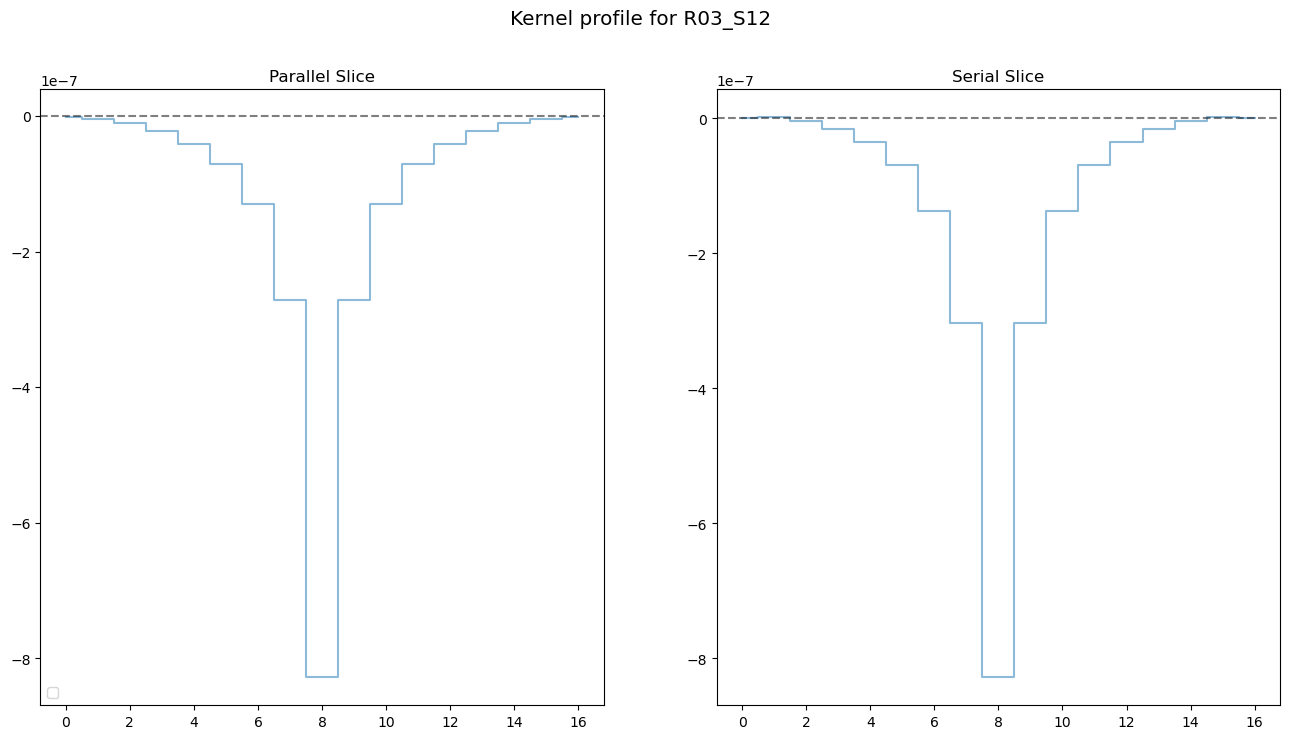

In [4]:
bfk = butler.get('bfk', detector=23, instrument='LSSTCam', collections='u/abrought/BF/2023.01.26/bfks.2023.01.26.max100kE.noQuadFit.corrModelr_3')
ptc = butler.get('ptc', detector=23, instrument='LSSTCam', collections='u/abrought/BF/2023.01.26/ptc.2023.01.26.max100kE')


def avg_matrix(d, exclude_channels=[]):
    if type(d["C00"]) == list:
        for key in d:
            d[key] = np.asarray(d[key])
    t = np.zeros(d["C00"].shape)
    for k,channel in zip(d.values(), d.keys()):
        if channel in exclude_channels:
            continue
        t += k
    return t / len(d.values())

mu = avg_matrix(bfk.ampKernels)


fig, axs = plt.subplots(1,2, figsize=(16,8), facecolor='w')
plt.suptitle("Kernel profile for " + sensor, fontsize="x-large")   
axs[0].plot(mu[:,8], drawstyle='steps-mid', alpha=0.5)
axs[1].plot(mu[8,:], drawstyle='steps-mid', alpha=0.5)

axs[0].axhline(0.0,linestyle="--", color="black", alpha=0.5)
axs[1].axhline(0.0,linestyle="--", color="black", alpha=0.5)
axs[0].legend(loc=3)

axs[0].set_title("Parallel Slice")
axs[1].set_title("Serial Slice")

In [5]:
A = avg_matrix(ptc.aMatrix)


Text(0.5, 1.0, 'Serial Slice')

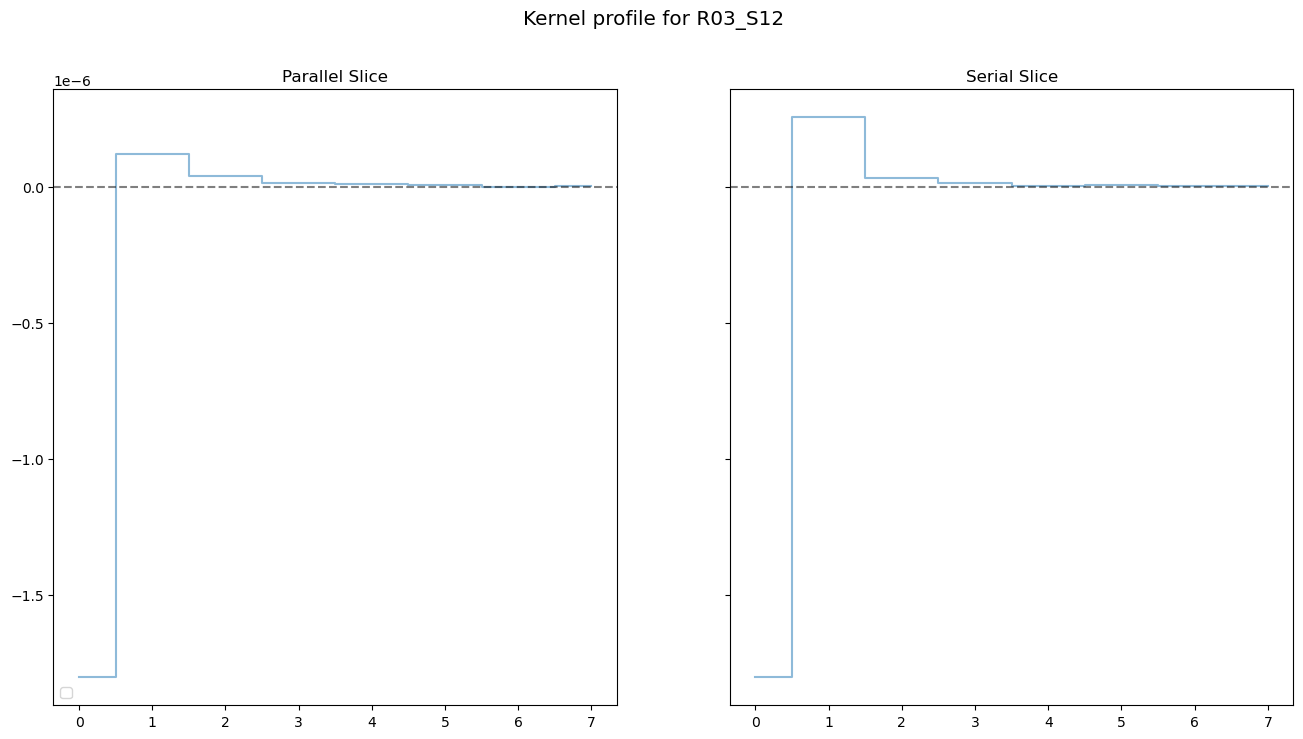

In [6]:
fig, axs = plt.subplots(1,2, figsize=(16,8), sharey=True, facecolor='w')
plt.suptitle("Kernel profile for " + sensor, fontsize="x-large")   
axs[0].plot(A[:,0], drawstyle='steps-mid', alpha=0.5)
axs[1].plot(A[0,:], drawstyle='steps-mid', alpha=0.5)

axs[0].axhline(0.0,linestyle="--", color="black", alpha=0.5)
axs[1].axhline(0.0,linestyle="--", color="black", alpha=0.5)
axs[0].legend(loc=3)

axs[0].set_title("Parallel Slice")
axs[1].set_title("Serial Slice")

In [7]:
from scipy.signal import convolve2d
def bf_correction(image, A):
    # From Antilogus
    
    #shape = image.shape
    
    # Get charge contribution
    #def delta_ij(i, j, A, image):
    #    sum_kl = 0.0
    #    for k in range(8):
    #        for l in range(8):
    #            sum_kl += A[k,l] * image[i-k][j-l]

    #    return 0.5 * sum_kl

    dQ = 0.5 * convolve2d(image, A)[0:image.shape[0],0:image.shape[1]]
    #dQ = np.zeros(image.shape)
    #for i in range(image.shape[0]):
    #    for j in range(image.shape[1]):
    #        dQ[i,j] = delta_ij(i,j,a,Q)
    
    return image + dQ

In [8]:
import lsst.afw.image as afwImage

def display(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')

In [8]:
# Get the uncorrected flat images


repo_path = "/sdf/group/rubin/repo/main/"
butler = Butler(repo_path)
registry = butler.registry


sensor = "R24_S11"
det = 112

datasetRefs = butler.registry.queryDatasets('cpPtcProc',collections='u/abrought/BF/2023.01.26/ptc.2023.01.26', 
                                            detector=112,
                                            instrument='LSSTCam',
                                            where=f"instrument='LSSTCam' AND exposure.observation_type='flat' ")


In [53]:
# Plot the uncorrected PTC
mu = []
var = []
for i, ref in enumerate(datasetRefs):
    ptcProc = butler.get('cpPtcProc',dataId=ref.dataId, collections='u/abrought/BF/2023.01.26/ptc.2023.01.26')
    mu.append(np.mean(ptcProc.getImage().getArray()))
    var.append(np.var(ptcProc.getImage().getArray()))
    #display(ptcProc)
    if i == 100:
        break

Text(0, 0.5, 'Variance')

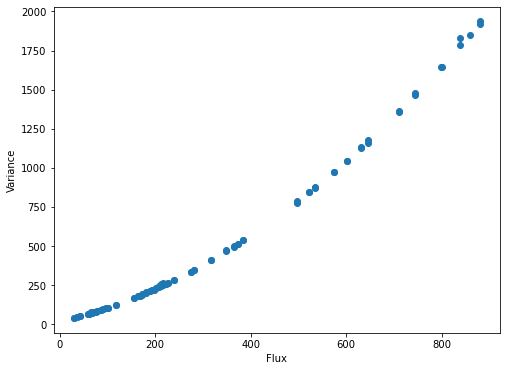

In [54]:
plt.figure(figsize=(8,6))
plt.scatter(mu,var)
plt.xlabel("Flux")
plt.ylabel("Variance")

In [14]:
# Plot the corrected PTC

from lsst.obs.lsst import LsstCam
camera = LsstCam().getCamera()
    
mu = {'C10':[],'C11':[],'C12':[],'C13':[],\
      'C14':[],'C15':[],'C16':[],'C17':[],\
      'C07':[],'C06':[],'C05':[],'C04':[],\
      'C03':[],'C02':[],'C01':[],'C00':[]}

var = {'C10':[],'C11':[],'C12':[],'C13':[],\
      'C14':[],'C15':[],'C16':[],'C17':[],\
      'C07':[],'C06':[],'C05':[],'C04':[],\
      'C03':[],'C02':[],'C01':[],'C00':[]}

for i, ref in enumerate(datasetRefs):
    # Get the extracted image
    ptcProc = butler.get('cpPtcProc',dataId=ref.dataId, collections='u/abrought/BF/2023.01.26/ptc.2023.01.26')
    # Loop through the amplifiers
    for j, amp in enumerate(camera[0].getAmplifiers()):
        amp_image = ptcProc.getImage().subset(amp.getBBox())
        amp_image = bf_correction(amp_image.getArray(), A)
        
        mu[amp.getName()].append(np.mean(amp_image))
        var[amp.getName()].append(np.var(amp_image))
        print(i, amp.getName(), np.mean(amp_image), np.var(amp_image), end ="\r")

    #display(ptcProc)
    
    if i+1 == 0:
        break



Help on ImageF in module lsst.afw.image.image object:

class ImageF(ImageBaseF)
 |  Method resolution order:
 |      ImageF
 |      ImageBaseF
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  Factory(self, *args, **kwargs)
 |      Return an object of this type
 |  
 |  __add__ = notImplemented(self, other)
 |      Provide a helpful error message about image arithmetic
 |      
 |      Unless we're operating on an ImageSlice, in which case it might be
 |      defined.
 |      
 |      Parameters
 |      ----------
 |      self : subclass of `lsst.afw.image.ImageBase`
 |          Image someone's attempting to do arithmetic with.
 |      other : anything
 |          The operand of the arithmetic operation.
 |  
 |  __getitem__(self, imageSlice)
 |  
 |  __iadd__(...)
 |      __iadd__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __iadd__(self: lsst.afw.image.image.ImageF, arg0: lsst::afw::image::ImageSlice<float>

ERROR:timer.lsst.daf.butler.datastores.fileDatastore:Reading from location file:///sdf/group/rubin/repo/main/u/abrought/BF/2023.01.26/ptc.2023.01.26/20230127T011102Z/cpPtcProc/20211206/MC_C_20211206_000579/cpPtcProc_LSSTCam_SDSSi~ND_OD0_5_MC_C_20211206_000579_R24_S11_u_abrought_BF_2023_01_26_ptc_2023_01_26_20230127T011102Z.fits  with formatter lsst.obs.base.formatters.fitsExposure.FitsExposureFormatter: Took 0.7338 seconds
Exception ignored in: <function _collection_gced at 0x7f78a1d6a560>
Traceback (most recent call last):
  File "/sdf/group/rubin/sw/conda/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/sqlalchemy/event/registry.py", line 53, in _collection_gced
    def _collection_gced(ref):
KeyboardInterrupt: 


KeyboardInterrupt: 

Text(0, 0.5, 'Variance')

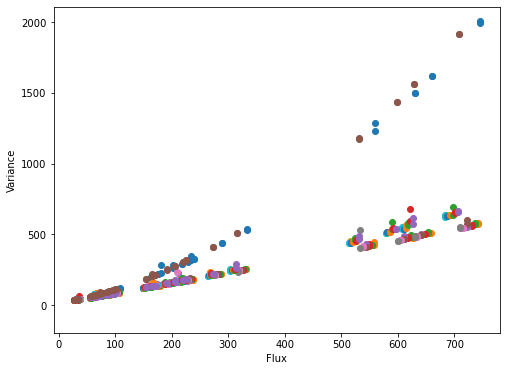

In [71]:
plt.figure(figsize=(8,6))
for j, amp in enumerate(camera[0].getAmplifiers()):
    plt.scatter(mu[amp.getName()],var[amp.getName()], label=amp.getName())
    m,b = np.polyfit(mu[amp.getName()],var[amp.getName()], 1)
    x = np.linspace(np.min(mu[amp.getName()]), np.max(np.min(mu[amp.getName()])), 100)
    plt.plot(x, m*x + b, "r--")
plt.xlabel("Flux")
plt.ylabel("Variance")

### Read in from file

In [9]:
with open('mu.pickle', 'rb') as handle:
    mu = pkl.load(handle)
with open('mu_corrected.pickle', 'rb') as handle:
    mu_corrected = pkl.load(handle)
with open('var.pickle', 'rb') as handle:
    var = pkl.load(handle)
with open('var_corrected.pickle', 'rb') as handle:
    var_corrected = pkl.load(handle)

### Uncorrected

(0.0, 5000000.0)

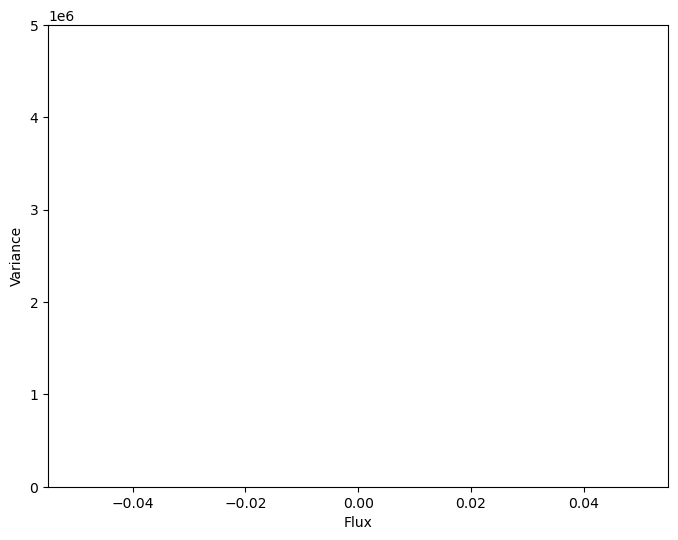

In [14]:
plt.figure(figsize=(8,6))
for j, amp in enumerate(camera[0].getAmplifiers()):
    plt.scatter(mu[amp.getName()],var[amp.getName()], label=amp.getName())
plt.xlabel("Flux")
plt.ylabel("Variance")
plt.ylim(0,.5e7)

### Corrected

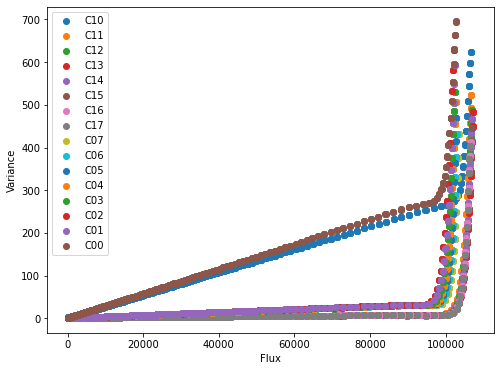

In [11]:
plt.figure(figsize=(8,6))
for j, amp in enumerate(camera[0].getAmplifiers()):
    plt.scatter(mu_corrected[amp.getName()],np.asarray(var_corrected[amp.getName()])/np.asarray(mu_corrected[amp.getName()]), label=amp.getName())
plt.xlabel("Flux")
plt.ylabel("Variance")
#plt.ylim(0,0.2e7)
plt.legend()

## Using DM

In [9]:
from scipy.signal import convolve2d
def bf_correction(image, A):
    # From Antilogus
    
    dQ = 0.5 * convolve2d(image, A)[0:image.shape[0],0:image.shape[1]]
    
    return image + dQ

In [10]:
# Get the uncorrected flat images


repo_path = "/sdf/group/rubin/repo/main/"
butler = Butler(repo_path)
registry = butler.registry


sensor = "R24_S11"
det = 112

datasetRefs = butler.registry.queryDatasets('cpPtcProc',collections='u/abrought/BF/2023.01.26/ptc.2023.01.26', 
                                            detector=112,
                                            instrument='LSSTCam',
                                            where=f"instrument='LSSTCam' AND exposure.observation_type='flat' ")


In [12]:
# Plot the corrected PTC

from lsst.obs.lsst import LsstCam
import lsst.afw.image as afwImage
camera = LsstCam().getCamera()
    
mu = {'C10':[],'C11':[],'C12':[],'C13':[],\
      'C14':[],'C15':[],'C16':[],'C17':[],\
      'C07':[],'C06':[],'C05':[],'C04':[],\
      'C03':[],'C02':[],'C01':[],'C00':[]}

var = {'C10':[],'C11':[],'C12':[],'C13':[],\
      'C14':[],'C15':[],'C16':[],'C17':[],\
      'C07':[],'C06':[],'C05':[],'C04':[],\
      'C03':[],'C02':[],'C01':[],'C00':[]}

for i, ref in enumerate(datasetRefs):
    # Get the extracted image
    ptcProc = butler.get('cpPtcProc',dataId=ref.dataId, collections='u/abrought/BF/2023.01.26/ptc.2023.01.26')
    help(ref)
    print(np.var(ptcProc.getImage().getArray()[10:-10,10:-10]))
    
    image = afwImage.ImageF(np.asarray(bf_correction(ptcProc.getImage().getArray(), A), dtype = np.float32))
    ptcProc.setImage(image)

    print(np.var(ptcProc.getImage().getArray()))
    #display(ptcProc)
    
    if i+1 == 1:
        break



Help on DatasetRef in module lsst.daf.butler.core.datasets.ref object:

class DatasetRef(builtins.object)
 |  DatasetRef(datasetType: 'DatasetType', dataId: 'DataCoordinate', *, id: 'Optional[DatasetId]' = None, run: 'Optional[str]' = None, conform: 'bool' = True)
 |  
 |  Reference to a Dataset in a `Registry`.
 |  
 |  A `DatasetRef` may point to a Dataset that currently does not yet exist
 |  (e.g., because it is a predicted input for provenance).
 |  
 |  Parameters
 |  ----------
 |  datasetType : `DatasetType`
 |      The `DatasetType` for this Dataset.
 |  dataId : `DataCoordinate`
 |      A mapping of dimensions that labels the Dataset within a Collection.
 |  id : `DatasetId`, optional
 |      The unique identifier assigned when the dataset is created.
 |  run : `str`, optional
 |      The name of the run this dataset was associated with when it was
 |      created.  Must be provided if ``id`` is.
 |  conform : `bool`, optional
 |      If `True` (default), call `DataCoordinate

## Antilogus+14 on PTC

Coulton Correction:

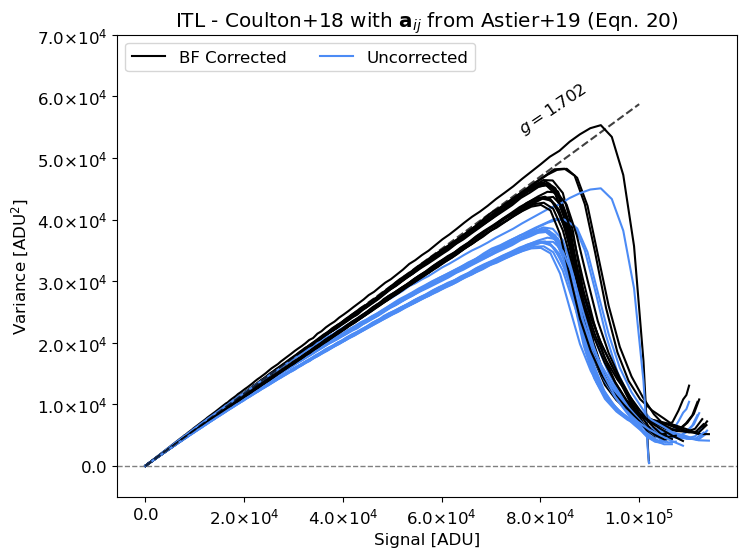

In [12]:
from scipy import stats
from scipy import interpolate
import matplotlib.ticker as mticker
from matplotlib.pyplot import cm
plt.rcParams.update({'font.size': 12})
sensor = 'R03-S12'
ptc_linearized = butler.get('ptc', detector=23, instrument='LSSTCam', collections='u/abrought/BF/2023.01.26/ptc.2023.01.26.BFCorrected')
ptc_linearized_2 = butler.get('ptc', detector=23, instrument='LSSTCam', collections='u/abrought/BF/2023.01.26/ptc.2023.01.26')
#fig, axs = plt.subplots(2,8, sharex=True, sharey=True, figsize=(20,5), facecolor='w')

class MathTextSciFormatter(mticker.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            s =  r'%s%s' % (significand, exponent)
        return "${}$".format(s)

ptc_turnoffs = []
ptc_turnoffs2 = []
means = []
means_2 = []
gains = []

flux_new = np.arange(1000., 105000., 200)
pts = np.full(flux_new.shape, np.nan)
pts1 = np.full(flux_new.shape, np.nan)
fig = plt.figure(figsize=(8,6))
#fig, axs = plt.subplots(3,1, sharex=True, figsize=(10,10))
#plt.suptitle("PTC for " + sensor + " Run 13144", fontsize="x-large")  
plt.axhline(0.0, linestyle="--", color="k", alpha=0.5, linewidth=1.)
color = cm.tab20(np.linspace(0, 1, 16))
for i, amp in enumerate(camera[0].getAmplifiers()):
    mask = np.asarray(ptc_linearized.rawExpTimes[amp.getName()]) < 500.
    gains.append(ptc_linearized_2.gain[amp.getName()])
    mask_2 = np.asarray(ptc_linearized_2.rawExpTimes[amp.getName()]) < 500.
    means.extend(np.asarray(ptc_linearized.rawMeans[amp.getName()])[mask])
    means_2.extend(np.asarray(ptc_linearized_2.rawMeans[amp.getName()])[mask_2])
    #ax = axs[0 if i < 8 else 1][i if i < 8 else i-8]
    flux = [mean for mean in np.asarray(ptc_linearized.rawMeans[amp.getName()])[mask]]
    flux_2 = [mean_2 for mean_2 in np.asarray(ptc_linearized_2.rawMeans[amp.getName()])[mask_2]]
    
    #flux2 = [mean * ptc.gain[amp.getName()] for mean in ptc.rawMeans[amp.getName()]]
    #im2 = plt.plot(flux2, ptc.rawVars[amp.getName()])
    #plt.xlim(0,np.max(flux))
    #hist, bin_edges = np.histogram(flux, bins=100)
    #indxs = np.digitize(flux2, bin_edges)
    #statistic, bin_edges, _ =stats.binned_statistic(flux, np.asarray(ptc_linearized.rawVars[amp.getName()])[mask], 'mean', bins=100, range=(np.min(flux), np.max(flux)))
    #statistic2, bin_edges2, _ =stats.binned_statistic(flux_2, np.asarray(ptc_linearized_2.rawVars[amp.getName()])[mask_2], 'mean', bins=100, range=(np.min(flux_2), np.max(flux_2)))

    if i  == 0:
        f = plt.plot(flux, np.asarray(ptc_linearized.rawVars[amp.getName()]), color="k", label="BF Corrected")
        #flux_new = np.arange(np.min(flux_2), np.max(flux_2), 200)
        #var_new = f(flux_new)
    
        f2 = plt.plot(flux_2, np.asarray(ptc_linearized_2.rawVars[amp.getName()]), color="#4c8bf5", label="Uncorrected")
    else:
    
        f = plt.plot(flux, np.asarray(ptc_linearized.rawVars[amp.getName()]), color="k")
        #flux_new = np.arange(np.min(flux_2), np.max(flux_2), 200)
        #var_new = f(flux_new)

        f2 = plt.plot(flux_2, np.asarray(ptc_linearized_2.rawVars[amp.getName()]), color="#4c8bf5",)
        #var_new2 = f2(flux_new)

    #pts = np.vstack((pts, var_new2))
    #pts1 = np.vstack((pts1, var_new))
    #print(pts.shape)

#pts = np.nanmean(pts, axis=0)
#pts1 = np.nanmean(pts1, axis=0)
#ptserrs = np.nanstd(pts, axis=0)
#ptserrs1 = np.nanstd(pts1, axis=0)

#plt.plot(flux, np.asarray(ptc_linearized.rawVars[amp.getName()])[mask], ms=5, color="#1aa260", alpha=0.3)
#plt.fill_between(flux_new, pts1-(ptserrs1/np.sqrt(16)), pts1+(ptserrs1/np.sqrt(16)), color="#1aa260", alpha=0.3)
#plt.plot(flux_new, pts1, color="#1aa260")
#plt.fill_between(flux_new, pts-(ptserrs/np.sqrt(16)), pts+(ptserrs/np.sqrt(16)), color="#4c8bf5", alpha=0.3)
#plt.plot(flux_new, pts, color="#4c8bf5")
#plt.fill_between()
#axs[2].plot(flux_new, var_new-var_new2, "-", c=color[i])
#axs[0].set_title("BF Corrected")
#axs[0].set_ylabel("Var [ADU^2]")
#axs[1].set_ylabel("Var [ADU^2]")
#axs[1].set_title("Not BF Corrected")
#plt.legend(loc='upper left',ncol=2)
# axs[0].set_ylim(-1000.,60000.)
#axs[1].set_ylim(-1000.,60000.)
plt.plot(np.linspace(0.,100000., 10), 1./np.mean(gains) * np.linspace(0.,100000., 10), "k--", alpha=0.75)
#axs[1].plot(np.linspace(0.,100000., 10), .666 * np.linspace(0.,100000., 10), "r--")
#ax.axvline(flux[np.argmax(ptc_linearized.rawVars[amp.getName()])], linestyle="--", color="black", alpha=0.5)
#ax.text(10000, 33000, str(round(flux[np.argmax(ptc_linearized.rawVars[amp.getName()])], -1)))
#ptc_turnoffs.append(flux[np.argmax(ptc_linearized.rawVars[amp.getName()])])
#ptc_turnoffs2.append(flux2[np.argmax(ptc.rawVars[amp.getName()])])
    
#plt.axvline(66666.)
plt.title(r"ITL - Coulton+18 with $\mathbf{a}_{ij}$ from Astier+19 (Eqn. 20)")
plt.xlabel("Signal [ADU]")
plt.ylabel("Variance [ADU$^{2}$]")
plt.text(75000,54000,"$g=$" + str(round(np.mean(gains), 3)), rotation=90-56.22)
# Format with 2 decimal places
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.1e"))
plt.gca().xaxis.set_major_formatter(MathTextSciFormatter("%1.1e"))
#plt.ticklabel_format(style='scientific', axis='both', scilimits=(0,0))
#plt.xlim(0,80000)
plt.ylim(-0.5e4,7.0e4)
plt.legend(loc='upper left',ncol=2)
#plt.savefig("../plots/examplePTC.png", bbox_inches="tight")


In [13]:
def antilogus14(V, mu, A):
    return mu, V - 2.*V*mu*A[0][0]


(-5000.0, 70000.0)

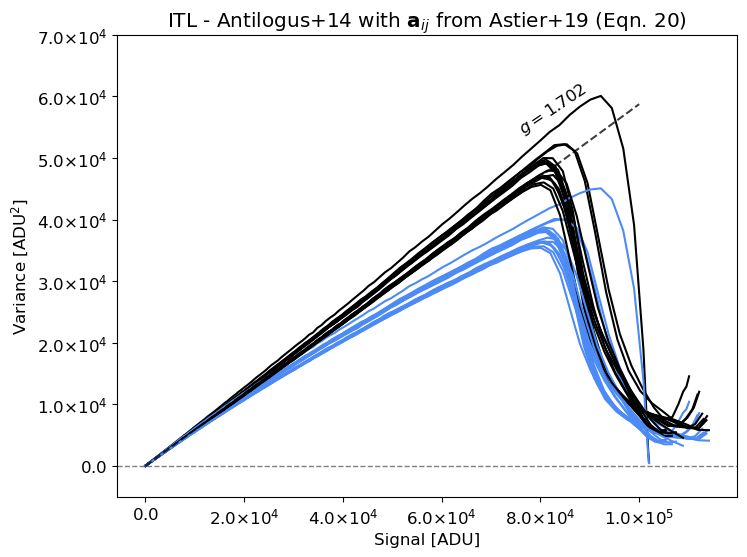

In [16]:
from scipy import stats
from scipy import interpolate
import matplotlib.ticker as mticker
from matplotlib.pyplot import cm
plt.rcParams.update({'font.size': 12})
sensor = 'R03-S12'
ptc_linearized = butler.get('ptc', detector=23, instrument='LSSTCam', collections='u/abrought/BF/2023.01.26/ptc.2023.01.26')
ptc_linearized_2 = butler.get('ptc', detector=23, instrument='LSSTCam', collections='u/abrought/BF/2023.01.26/ptc.2023.01.26')
#fig, axs = plt.subplots(2,8, sharex=True, sharey=True, figsize=(20,5), facecolor='w')

class MathTextSciFormatter(mticker.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            s =  r'%s%s' % (significand, exponent)
        return "${}$".format(s)

ptc_turnoffs = []
ptc_turnoffs2 = []
means = []
means_2 = []
gains = []

flux_new = np.arange(1000., 105000., 200)
pts_prime = np.full(flux_new.shape, np.nan)
pts1 = np.full(flux_new.shape, np.nan)
fig = plt.figure(figsize=(8,6))
#fig, axs = plt.subplots(3,1, sharex=True, figsize=(10,10))
#plt.suptitle("PTC for " + sensor + " Run 13144", fontsize="x-large")  
plt.axhline(0.0, linestyle="--", color="k", alpha=0.5, linewidth=1.)
color = cm.tab20(np.linspace(0, 1, 16))
for i, amp in enumerate(camera[0].getAmplifiers()):
    
    mask = np.asarray(ptc_linearized.rawExpTimes[amp.getName()]) < 500.
    gains.append(ptc_linearized_2.gain[amp.getName()])
    mask_2 = np.asarray(ptc_linearized_2.rawExpTimes[amp.getName()]) < 500.
    means.extend(np.asarray(ptc_linearized.rawMeans[amp.getName()])[mask])
    means_2.extend(np.asarray(ptc_linearized_2.rawMeans[amp.getName()])[mask_2])
    #ax = axs[0 if i < 8 else 1][i if i < 8 else i-8]
    flux = [mean for mean in np.asarray(ptc_linearized.rawMeans[amp.getName()])[mask]]
    flux_2 = [mean_2 for mean_2 in np.asarray(ptc_linearized_2.rawMeans[amp.getName()])[mask_2]]
    
    #flux2 = [mean * ptc.gain[amp.getName()] for mean in ptc.rawMeans[amp.getName()]]
    #im2 = plt.plot(flux2, ptc.rawVars[amp.getName()])
    #plt.xlim(0,np.max(flux))
    #hist, bin_edges = np.histogram(flux, bins=100)
    #indxs = np.digitize(flux2, bin_edges)
    #statistic, bin_edges, _ =stats.binned_statistic(flux, np.asarray(ptc_linearized.rawVars[amp.getName()])[mask], 'mean', bins=100, range=(np.min(flux), np.max(flux)))
    #statistic2, bin_edges2, _ =stats.binned_statistic(flux_2, np.asarray(ptc_linearized_2.rawVars[amp.getName()])[mask_2], 'mean', bins=100, range=(np.min(flux_2), np.max(flux_2)))

    flux2, var2_prime = antilogus14(np.asarray(ptc_linearized_2.rawVars[amp.getName()])[mask], flux_2, A)
    if i  == 0:
        f = plt.plot(flux2, var2_prime, color="k", label="BF Corrected")
        #flux_new = np.arange(np.min(flux_2), np.max(flux_2), 200)
        #var_new = f(flux_new)
    
        f2 = plt.plot(flux_2, np.asarray(ptc_linearized_2.rawVars[amp.getName()]), color="#4c8bf5", label="Uncorrected")
    else:
    
        f = plt.plot(flux2, var2_prime, color="k")
        #flux_new = np.arange(np.min(flux_2), np.max(flux_2), 200)
        #var_new = f(flux_new)

        f2 = plt.plot(flux_2, np.asarray(ptc_linearized_2.rawVars[amp.getName()]), color="#4c8bf5")

#pts_prime = np.nanmean(pts_prime, axis=0)
#pts1 = np.nanmean(pts1, axis=0)
#ptserrs_prime = np.nanstd(pts_prime, axis=0)
#ptserrs1 = np.nanstd(pts1, axis=0)

#plt.plot(flux, np.asarray(ptc_linearized.rawVars[amp.getName()])[mask], ms=5, color="#1aa260", alpha=0.3)
#plt.fill_between(flux_new, pts1-(ptserrs1/np.sqrt(16)), pts1+(ptserrs1/np.sqrt(16)), color="#4c8bf5", alpha=0.3)
#plt.plot(flux_new, pts1, color="#4c8bf5")
#plt.fill_between(flux_new, pts_prime-(ptserrs_prime/np.sqrt(16)), pts_prime+(ptserrs_prime/np.sqrt(16)), color="#1aa260", alpha=0.3)
#plt.plot(flux_new, pts_prime, color="#1aa260")
#plt.fill_between()
#axs[2].plot(flux_new, var_new-var_new2, "-", c=color[i])
#axs[0].set_title("BF Corrected")
#axs[0].set_ylabel("Var [ADU^2]")
#axs[1].set_ylabel("Var [ADU^2]")
#axs[1].set_title("Not BF Corrected")
#plt.legend(loc='upper left',ncol=2)
# axs[0].set_ylim(-1000.,60000.)
#axs[1].set_ylim(-1000.,60000.)
plt.plot(np.linspace(0.,100000., 10), 1./np.mean(gains) * np.linspace(0.,100000., 10), "k--", alpha=0.75)
#axs[1].plot(np.linspace(0.,100000., 10), .666 * np.linspace(0.,100000., 10), "r--")
#ax.axvline(flux[np.argmax(ptc_linearized.rawVars[amp.getName()])], linestyle="--", color="black", alpha=0.5)
#ax.text(10000, 33000, str(round(flux[np.argmax(ptc_linearized.rawVars[amp.getName()])], -1)))
#ptc_turnoffs.append(flux[np.argmax(ptc_linearized.rawVars[amp.getName()])])
#ptc_turnoffs2.append(flux2[np.argmax(ptc.rawVars[amp.getName()])])
    
#plt.axvline(66666.)
plt.title(r"ITL - Antilogus+14 with $\mathbf{a}_{ij}$ from Astier+19 (Eqn. 20)")
plt.xlabel("Signal [ADU]")
plt.ylabel("Variance [ADU$^{2}$]")
plt.text(75000,54000,"$g=$" + str(round(np.mean(gains), 3)), rotation=90-56.22)
# Format with 2 decimal places
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.1e"))
plt.gca().xaxis.set_major_formatter(MathTextSciFormatter("%1.1e"))
#plt.ticklabel_format(style='scientific', axis='both', scilimits=(0,0))
#plt.xlim(0,80000)
plt.ylim(-0.5e4,7.0e4)
#plt.legend(loc='upper left',ncol=2)
#plt.savefig("../plots/examplePTC.png", bbox_inches="tight")
